# How to create subgraphs

<div class="admonition tip">
    <p class="admonition-title">Prerequisites</p>
    <p>
        This guide assumes familiarity with the following:
        <ul>
            <li>            
                <a href="https://langchain-ai.github.io/langgraph/concepts/low_level/#state">
                    State
                </a>
            </li>
            <li>            
                <a href="https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers">
                    Reducers
                </a>
            </li>
            <li>            
                <a href="https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#sub-graphs">
                    Subgraphs
                </a>
            </li>
        </ul>
    </p>
</div> 

For more complex systems, subgraphs are a useful design principle. Subgraphs allow you to create and manage different states in different parts of your graph. This allows you build things like [multi-agent teams](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams/), where each team can track its own separate state. This guide shows how you can add subgraphs to your graph.

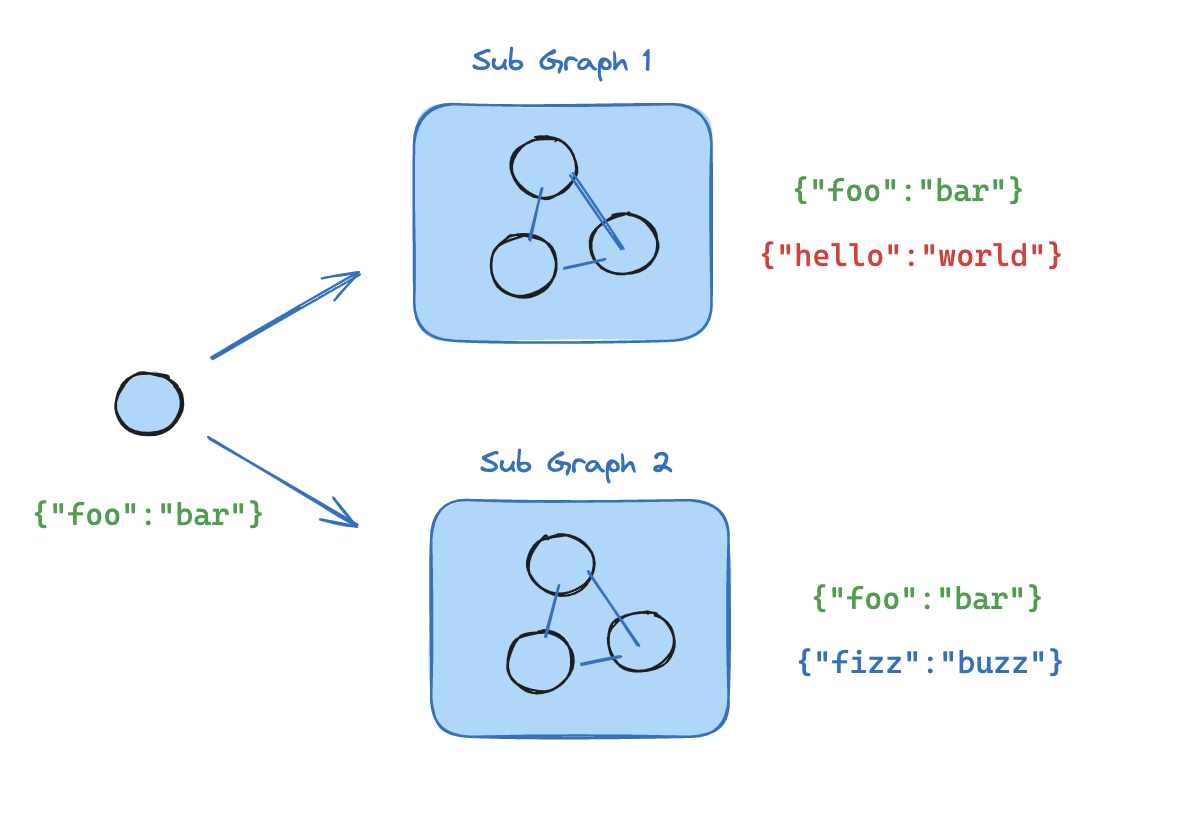

## Setup

First, let's install the required packages

In [1]:
%%capture --no-stderr
%pip install -U langgraph

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>    

## Simple example

Let's consider a toy example: a system that accepts logs and perform two separate sub-tasks. First, it will summarize them. Second, it will summarize any failure modes captured in the logs. These two operations will be performed by two different subgraphs.

The most important thing to recognize is the information transfer between the graphs. `Entry Graph` is the parent, and each of the two subgraphs are defined as nodes in `Entry Graph`. Both subgraphs inherit state from the parent `Entry Graph`; I can access `docs` in each of the subgraphs simply by specifying it in the subgraph state (see diagram). Each subgraph can have its own private state. And any values that I want propagated back to the parent `Entry Graph` (for final reporting) simply need to be defined in my `Entry Graph` state (e.g., `summary report` and `failure report`).

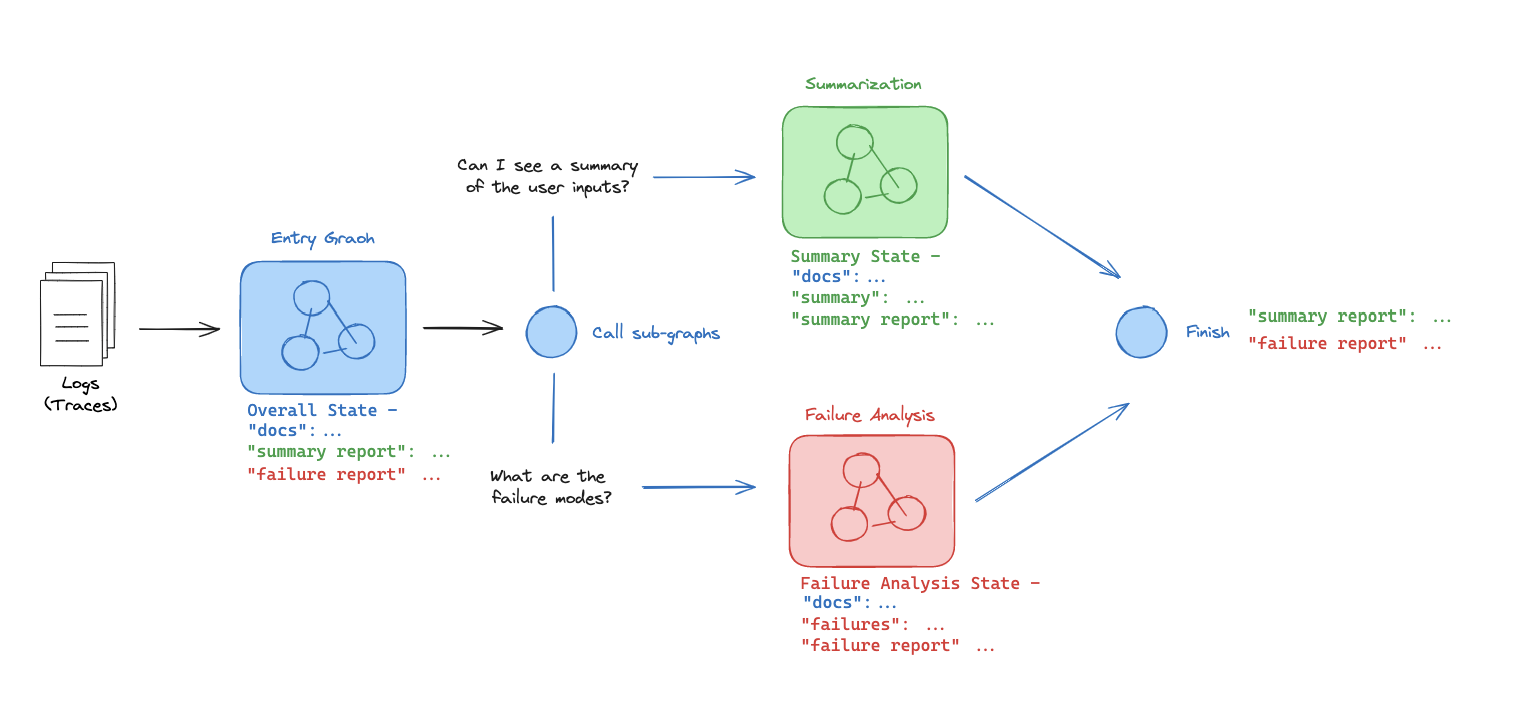

### Define subgraphs

In [2]:
from typing import Optional, Annotated
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END


# The structure of the logs
class Logs(TypedDict):
    id: str
    question: str
    answer: str
    grade: Optional[int]
    feedback: Optional[str]


# Define custom reducer (see more on this in the "Custom reducer" section below)
def add_logs(left: list[Logs], right: list[Logs]) -> list[Logs]:
    if not left:
        left = []

    if not right:
        right = []

    logs = left.copy()
    left_id_to_idx = {log["id"]: idx for idx, log in enumerate(logs)}
    # update if the new logs are already in the state, otherwise append
    for log in right:
        idx = left_id_to_idx.get(log["id"])
        if idx is not None:
            logs[idx] = log
        else:
            logs.append(log)
    return logs


# Failure Analysis Subgraph
class FailureAnalysisState(TypedDict):
    # keys shared with the parent graph (EntryGraphState)
    logs: Annotated[list[Logs], add_logs]
    failure_report: str
    # subgraph key
    failures: list[Logs]


def get_failures(state: FailureAnalysisState):
    failures = [log for log in state["logs"] if log["grade"] == 0]
    return {"failures": failures}


def generate_summary(state: FailureAnalysisState):
    failures = state["failures"]
    # NOTE: you can implement custom summarization logic here
    failure_ids = [log["id"] for log in failures]
    fa_summary = f"Poor quality of retrieval for document IDs: {', '.join(failure_ids)}"
    return {"failure_report": fa_summary}


fa_builder = StateGraph(FailureAnalysisState)
fa_builder.add_node("get_failures", get_failures)
fa_builder.add_node("generate_summary", generate_summary)
fa_builder.add_edge(START, "get_failures")
fa_builder.add_edge("get_failures", "generate_summary")
fa_builder.add_edge("generate_summary", END)


# Summarization subgraph
class QuestionSummarizationState(TypedDict):
    # keys that are shared with the parent graph (EntryGraphState)
    summary_report: str
    logs: Annotated[list[Logs], add_logs]
    # subgraph keys
    summary: str


def generate_summary(state: QuestionSummarizationState):
    docs = state["logs"]
    # NOTE: you can implement custom summarization logic here
    summary = "Questions focused on usage of ChatOllama and Chroma vector store."
    return {"summary": summary}


def send_to_slack(state: QuestionSummarizationState):
    summary = state["summary"]
    # NOTE: you can implement custom logic here, for example sending the summary generated in the previous step to Slack
    return {"summary_report": summary}


qs_builder = StateGraph(QuestionSummarizationState)
qs_builder.add_node("generate_summary", generate_summary)
qs_builder.add_node("send_to_slack", send_to_slack)
qs_builder.add_edge(START, "generate_summary")
qs_builder.add_edge("generate_summary", "send_to_slack")
qs_builder.add_edge("send_to_slack", END)

Note that each subgraph has its own state, `QuestionSummarizationState` and `FailureAnalysisState`.
 
After defining each subgraph, we put everything together.

### Define parent graph

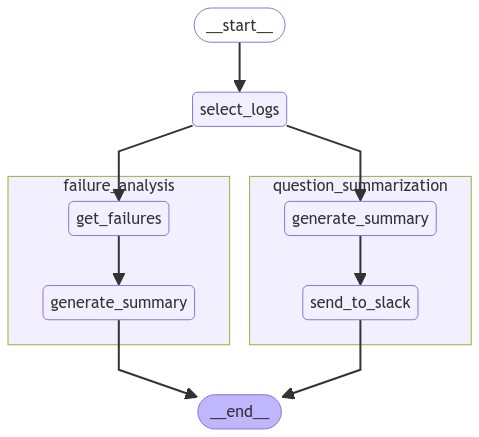

In [3]:
# Dummy logs
dummy_logs = [
    Logs(
        id="1",
        question="How can I import ChatOllama?",
        grade=1,
        answer="To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'",
    ),
    Logs(
        id="2",
        question="How can I use Chroma vector store?",
        answer="To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).",
        grade=0,
        feedback="The retrieved documents discuss vector stores in general, but not Chroma specifically",
    ),
    Logs(
        id="3",
        question="How do I create react agent in langgraph?",
        answer="from langgraph.prebuilt import create_react_agent",
    ),
]


# Entry Graph
class EntryGraphState(TypedDict):
    raw_logs: Annotated[list[Logs], add_logs]
    logs: Annotated[list[Logs], add_logs]  # This will be used in subgraphs
    failure_report: str  # This will be generated in the FA subgraph
    summary_report: str  # This will be generated in the QS subgraph


def select_logs(state):
    return {"logs": [log for log in state["raw_logs"] if "grade" in log]}


entry_builder = StateGraph(EntryGraphState)
entry_builder.add_node("select_logs", select_logs)
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())

entry_builder.add_edge(START, "select_logs")
entry_builder.add_edge("select_logs", "failure_analysis")
entry_builder.add_edge("select_logs", "question_summarization")
entry_builder.add_edge("failure_analysis", END)
entry_builder.add_edge("question_summarization", END)

graph = entry_builder.compile()

from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [4]:
graph.invoke({"raw_logs": dummy_logs}, debug=False)

{'raw_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'grade': 1,
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'feedback': 'The retrieved documents discuss vector stores in general, but not Chroma specifically'},
  {'id': '3',
   'question': 'How do I create react agent in langgraph?',
   'answer': 'from langgraph.prebuilt import create_react_agent'}],
 'logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'grade': 1,
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade'

## Custom reducer functions to manage state

You might have noticed that we defined a custom [reducer]([reducer](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) function (`add_logs`) or the `logs` key in `EntryGraphState`. It is necessary to provide a reducer when using shared state keys across multiple subgraphs.

Let's take a look at implementing a custom reducer. We will create two graphs: a parent graph with a few nodes and a child graph that is added as a node in the parent. We'll also define a custom reducer function (`reduce_list`) for our state. This is functionally equivalent to simply using `operator.add`.

In [5]:
from typing import Annotated

from typing_extensions import TypedDict


# define a simple reducer
def reduce_list(left: list, right: list) -> list:
    if not left:
        left = []
    if not right:
        right = []
    return left + right


# define parent and child state
class ChildState(TypedDict):
    name: str
    path: Annotated[list[str], reduce_list]


class ParentState(TypedDict):
    name: str
    path: Annotated[list[str], reduce_list]


# define a helper to build the graph
def make_graph(parent_schema, child_schema):
    child_builder = StateGraph(child_schema)

    child_builder.add_node("child_start", lambda state: {"path": ["child_start"]})
    child_builder.add_edge(START, "child_start")
    child_builder.add_node("child_middle", lambda state: {"path": ["child_middle"]})
    child_builder.add_node("child_end", lambda state: {"path": ["child_end"]})
    child_builder.add_edge("child_start", "child_middle")
    child_builder.add_edge("child_middle", "child_end")
    child_builder.add_edge("child_end", END)

    builder = StateGraph(parent_schema)

    builder.add_node("grandparent", lambda state: {"path": ["grandparent"]})
    builder.add_edge(START, "grandparent")
    builder.add_node("parent", lambda state: {"path": ["parent"]})
    builder.add_node("child", child_builder.compile())
    builder.add_node("sibling", lambda state: {"path": ["sibling"]})
    builder.add_node("fin", lambda state: {"path": ["fin"]})

    # Add connections
    builder.add_edge("grandparent", "parent")
    builder.add_edge("parent", "child")
    builder.add_edge("parent", "sibling")
    builder.add_edge("child", "fin")
    builder.add_edge("sibling", "fin")
    builder.add_edge("fin", END)
    graph = builder.compile()
    return graph


graph = make_graph(ParentState, ChildState)

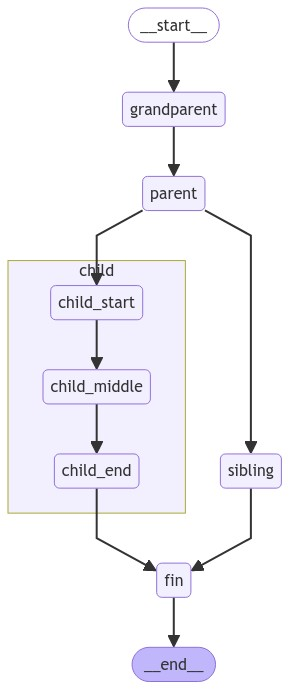

In [6]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [7]:
graph.invoke({"name": "test"}, debug=True)

[-2:checkpoint] State at the end of step -2:
{'path': []}
[0:tasks] Starting step 0 with 1 task:
- __start__ -> {'name': 'test'}
[0:writes] Finished step 0 with writes to 1 channel:
- name -> 'test'
[-2:checkpoint] State at the end of step -2:
{'name': 'test', 'path': []}
[1:tasks] Starting step 1 with 1 task:
- grandparent -> {'name': 'test', 'path': []}
[1:writes] Finished step 1 with writes to 1 channel:
- path -> ['grandparent']
[-2:checkpoint] State at the end of step -2:
{'name': 'test', 'path': ['grandparent']}
[2:tasks] Starting step 2 with 1 task:
- parent -> {'name': 'test', 'path': ['grandparent']}
[2:writes] Finished step 2 with writes to 1 channel:
- path -> ['parent']
[-2:checkpoint] State at the end of step -2:
{'name': 'test', 'path': ['grandparent', 'parent']}
[3:tasks] Starting step 3 with 2 tasks:
- child -> {'name': 'test', 'path': ['grandparent', 'parent']}
- sibling -> {'name': 'test', 'path': ['grandparent', 'parent']}
[3:writes] Finished step 3 with writes to 2 

{'name': 'test',
 'path': ['grandparent',
  'parent',
  'grandparent',
  'parent',
  'child_start',
  'child_middle',
  'child_end',
  'sibling',
  'fin']}

Notice here that the `["grandparent", "parent"]` sequence is duplicated! 

This is because our child state has received the full parent state and returns the full parent state once it terminates. 

To avoid duplication or conflicts in state, you typically would do one or more of the following:

1. Handle duplicates in your `reducer` function.
2. Call the child graph from within a python function. In that function, handle the state as needed.  
3. Update the child graph keys to avoid conflicts. You would still need to ensure the output can be interpreted by the parent, however.

Let's re-implement the graph using technique (1) and add unique IDs for every value in the list. This is what is done in [`MessageGraph`](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.MessageGraph).

In [8]:
import uuid


def reduce_list(left: list | None, right: list | None) -> list:
    """Append the right-hand list, replacing any elements with the same id in the left-hand list."""
    if not left:
        left = []
    if not right:
        right = []
    left_, right_ = [], []
    for orig, new in [(left, left_), (right, right_)]:
        for val in orig:
            if not isinstance(val, dict):
                val = {"val": val}
            if "id" not in val:
                val["id"] = str(uuid.uuid4())
            new.append(val)
    # Merge the two lists
    left_idx_by_id = {val["id"]: i for i, val in enumerate(left_)}
    merged = left_.copy()
    for val in right_:
        if (existing_idx := left_idx_by_id.get(val["id"])) is not None:
            merged[existing_idx] = val
        else:
            merged.append(val)
    return merged


class ChildState(TypedDict):
    name: str
    # note the updated reducer here
    path: Annotated[list[str], reduce_list]


class ParentState(TypedDict):
    name: str
    # note the updated reducer here
    path: Annotated[list[str], reduce_list]

Since our graph topology hasn't changed, we can just reuse the same `make_graph` helper function we defined previously and pass new schema for the parent and child graphs.

In [9]:
graph = make_graph(ParentState, ChildState)
graph.invoke({"name": "test"}, debug=True)

[-2:checkpoint] State at the end of step -2:
{'path': []}
[0:tasks] Starting step 0 with 1 task:
- __start__ -> {'name': 'test'}
[0:writes] Finished step 0 with writes to 1 channel:
- name -> 'test'
[-2:checkpoint] State at the end of step -2:
{'name': 'test', 'path': []}
[1:tasks] Starting step 1 with 1 task:
- grandparent -> {'name': 'test', 'path': []}
[1:writes] Finished step 1 with writes to 1 channel:
- path -> ['grandparent']
[-2:checkpoint] State at the end of step -2:
{'name': 'test',
 'path': [{'id': 'a3b7abbe-1083-40af-aa6f-23b39d6b5ab7', 'val': 'grandparent'}]}
[2:tasks] Starting step 2 with 1 task:
- parent -> {'name': 'test',
 'path': [{'id': 'a3b7abbe-1083-40af-aa6f-23b39d6b5ab7', 'val': 'grandparent'}]}
[2:writes] Finished step 2 with writes to 1 channel:
- path -> ['parent']
[-2:checkpoint] State at the end of step -2:
{'name': 'test',
 'path': [{'id': 'a3b7abbe-1083-40af-aa6f-23b39d6b5ab7', 'val': 'grandparent'},
          {'id': 'ce8522d8-5c45-4d0c-8e9f-42b11e9e5c6e'

{'name': 'test',
 'path': [{'val': 'grandparent', 'id': 'a3b7abbe-1083-40af-aa6f-23b39d6b5ab7'},
  {'val': 'parent', 'id': 'ce8522d8-5c45-4d0c-8e9f-42b11e9e5c6e'},
  {'val': 'child_start', 'id': '2c3d0366-9744-4ece-b3d5-95fa9727e5bf'},
  {'val': 'child_middle', 'id': 'b5920f7a-d722-43f2-86fa-cb9cb0dfdcc3'},
  {'val': 'child_end', 'id': '052b5578-6939-4dc0-8e24-0a13548a937e'},
  {'val': 'sibling', 'id': 'ff5e852c-3c71-4133-87a1-ec2e0b3a5b29'},
  {'val': 'fin', 'id': '82dc42d5-799b-4fad-8fbd-b12f32c179d2'}]}

You can see that that now the path values are no longer duplicated thanks to the updated reducer we introduced above.